# 00 Data Validation

Validates the already-generated canonical processed tables under `data/processed/`.
(No processing/writes run here.)

In [46]:

# Setup
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Detect project root
MARKERS = {"requirements.txt", "Projectplan.md", ".git"}
PROJECT_ROOT = None
cwd = Path.cwd()
for path in [cwd, *cwd.parents]:
    if any((path / m).exists() for m in MARKERS):
        PROJECT_ROOT = path
        break
if PROJECT_ROOT is None:
    PROJECT_ROOT = cwd

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DEFAULT_CANONICAL = DATA_PROCESSED / "canonical_original"
if DEFAULT_CANONICAL.exists():
    PROCESSED_DIR = DEFAULT_CANONICAL
else:
    candidates = [p for p in DATA_PROCESSED.iterdir() if (p / "participants.csv").exists()]
    PROCESSED_DIR = candidates[0] if candidates else DATA_PROCESSED

DATA_RAW = PROJECT_ROOT / "data" / "raw"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
FIGURES_DIR = OUTPUTS_DIR / "figures"
for p in [OUTPUTS_DIR, FIGURES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 160)
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})
sns.set_theme(style="whitegrid", palette="muted")

print(f"Project root: {PROJECT_ROOT}")
print(f"Processed dir: {PROCESSED_DIR}")


Project root: /Users/zeoxzhang/Dev/teamfight_tactic_s16_analytics
Processed dir: /Users/zeoxzhang/Dev/teamfight_tactic_s16_analytics/data/processed/canonical_original


In [47]:

# Load processed tables (canonical outputs)
participants = pd.read_csv(PROCESSED_DIR / "participants.csv")
traits = pd.read_csv(PROCESSED_DIR / "traits.csv")
units = pd.read_csv(PROCESSED_DIR / "units.csv")

# Reference lookups for integrity checks
units_ref = pd.read_csv(DATA_RAW / "units_s16.csv")
traits_ref = pd.read_csv(DATA_RAW / "traits_s16.csv")
items_ref = pd.read_csv(DATA_RAW / "items_s16.csv")


In [48]:

# Dataset overview
print("Participants:", participants.shape)
print("Traits:", traits.shape)
print("Units:", units.shape)
print("Matches:", participants['match_id'].nunique())
print("Players:", participants['puuid'].nunique())
row_counts = pd.Series({
    "participants": len(participants),
    "traits": len(traits),
    "units": len(units),
})
row_counts


Participants: (12797, 6)
Traits: (102570, 5)
Units: (113785, 8)
Matches: 1618
Players: 1311


participants     12797
traits          102570
units           113785
dtype: int64

In [49]:

# Schema checks vs required columns
required = {
    "participants": ["match_id", "puuid", "placement", "level", "last_round", "is_win"],
    "traits": ["match_id", "puuid", "trait_id", "num_units", "tier_current"],
    "units": ["match_id", "puuid", "unit_name", "unit_tier", "rarity", "item_0", "item_1", "item_2"],
}

for name, cols in required.items():
    df = locals()[name]
    missing = [c for c in cols if c not in df.columns]
    status = "OK" if not missing else f"MISSING {missing}"
    print(f"{name}: {status}")


participants: OK
traits: OK
units: OK


In [50]:

# Range checks with failures printed
failed = {}

placement_mask = ~participants['placement'].between(1, 8, inclusive='both')
if placement_mask.any():
    failed['placement_range'] = participants.loc[placement_mask, ['match_id','puuid','placement']]

level_mask = ~participants['level'].between(1, 10, inclusive='both')
if level_mask.any():
    failed['level_range'] = participants.loc[level_mask, ['match_id','puuid','level']]

unit_tier_mask = ~units['unit_tier'].between(1, 3, inclusive='both')
if unit_tier_mask.any():
    failed['unit_tier_range'] = units.loc[unit_tier_mask, ['match_id','puuid','unit_name','unit_tier']]

if not failed:
    print("[OK] All range checks passed")
else:
    for name, df in failed.items():
        print(f"[FAIL] {name}: {len(df)} rows")
        display(df.head())


[FAIL] unit_tier_range: 5 rows


,match_id,puuid,unit_name,unit_tier
4959,NA1_5432902531,1VlU3n5wOT5GyaZ6-UlZf7Wn5LT9t_xKw6oGea8hr6CDyQ...,Sion,4
26151,NA1_5432811140,6-5gF-paUe4jM9WonWQcSasJ4SsfBgyrUVoqm_KID69Atu...,atakhan,4
77553,NA1_5435739207,8eFHbMx-sXZ9Ln2YCH83KdC1CPidLzdyWQzQycA9zqM7an...,atakhan,4
85769,NA1_5435364823,qYROAwrh9iDpTdgmlD_-YFF0Zjpr0Lys9koPNMbFUJAqer...,Yasuo,4
88745,NA1_5435719792,CUw5QWzlzTjXnHUjfKyTpLZ8GiPM6kGhUZOjfmYHLzBUwR...,Briar,4


In [51]:

# Missing value analysis
missing_summary = {
    'participants': participants.isna().mean().sort_values(ascending=False),
    'traits': traits.isna().mean().sort_values(ascending=False),
    'units': units.isna().mean().sort_values(ascending=False),
}
missing_summary


{'participants': match_id      0.0
 puuid         0.0
 placement     0.0
 level         0.0
 last_round    0.0
 is_win        0.0
 dtype: float64,
 'traits': match_id        0.0
 puuid           0.0
 trait_id        0.0
 num_units       0.0
 tier_current    0.0
 dtype: float64,
 'units': item_2       0.598348
 item_1       0.530826
 item_0       0.445217
 match_id     0.000000
 puuid        0.000000
 unit_name    0.000000
 unit_tier    0.000000
 rarity       0.000000
 dtype: float64}

In [52]:

# Duplicates and empty boards
dup_participants = participants.duplicated(subset=["match_id", "puuid"]).sum()
print(f"Duplicate participant rows: {dup_participants}")

unit_counts = units.groupby(["match_id", "puuid"]).size().rename("unit_count")
empty_boards = unit_counts[unit_counts == 0]
print(f"Players with zero units recorded: {len(empty_boards)}")


Duplicate participant rows: 2
Players with zero units recorded: 0


In [53]:

# Reference integrity checks against static lookups (show offending rows)
unit_unknown = set(units['unit_name'].dropna()) - set(units_ref['name'].dropna())
trait_unknown = set(traits['trait_id'].dropna()) - set(traits_ref['name'].dropna())

if unit_unknown:
    print(f"Unknown unit names ({len(unit_unknown)}):", sorted(list(unit_unknown))[:10])
    unknown_unit_rows = units[units['unit_name'].isin(unit_unknown)][['match_id','puuid','unit_name']].head()
    display(unknown_unit_rows)
else:
    print("Unknown unit names: 0")

if trait_unknown:
    print(f"Unknown trait ids ({len(trait_unknown)}):", sorted(list(trait_unknown))[:10])
    unknown_trait_rows = traits[traits['trait_id'].isin(trait_unknown)][['match_id','puuid','trait_id']].head()
    display(unknown_trait_rows)
else:
    print("Unknown trait ids: 0")


Unknown unit names (1): ['atakhan']


,match_id,puuid,unit_name
182,NA1_5433906625,dleGSwAyBJqy0Y4lyo-xru_UEOwajuXUiYyhbpfvjmjHge...,atakhan
202,NA1_5433906625,mwujS7lBvn0dtUqd2gn9NukxZ7gYBvAA20MpmRatS1l-sA...,atakhan
334,NA1_5435349627,sk9Tmi2CqxaSG9Y282pWpR57clPPXGLlovFyHf9aqDUKRo...,atakhan
425,NA1_5432168991,mEOFFuSgVsJcu7HhdhREs5IzLO0tJL07MGc89kWFmpQJLj...,atakhan
454,NA1_5430737381,wp0I-Gp73k9kSPDWYM-cGPXJNH_VJv6ndeyUh5RPSeevc6...,atakhan


Unknown trait ids (22): ['AatroxUnique', 'AmbessaKindred', 'AurelionSolUnique', 'BaronUnique', 'Brawler', 'DarkinWeapon', 'Explorer', 'JarvanShyvana', 'KaisaUnique', 'KindredUnique']


,match_id,puuid,trait_id
0,NA1_5433864382,i5MHAVvrBlVtESxG0aC5lB4Rzqix40AnvDhuMFu1TYjF1_...,Brawler
3,NA1_5433864382,i5MHAVvrBlVtESxG0aC5lB4Rzqix40AnvDhuMFu1TYjF1_...,ShyvanaUnique
4,NA1_5433864382,i5MHAVvrBlVtESxG0aC5lB4Rzqix40AnvDhuMFu1TYjF1_...,Sorcerer
8,NA1_5433864382,i5MHAVvrBlVtESxG0aC5lB4Rzqix40AnvDhuMFu1TYjF1_...,Yordle
9,NA1_5433864382,SZ-F42COa-Tmzd4AK9F7fA2rnrSotOET2ZU6TN9W201prZ...,Brawler


/var/folders/tg/_44xm62x005bmxbkcr03sx280000gn/T/ipykernel_10697/347680971.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  items_long = units[['unit_name'] + item_cols].set_index('unit_name').stack(dropna=True).reset_index()


Saved item heatmap to /Users/zeoxzhang/Dev/teamfight_tactic_s16_analytics/outputs/figures/00_data_validation_items_heatmap.png


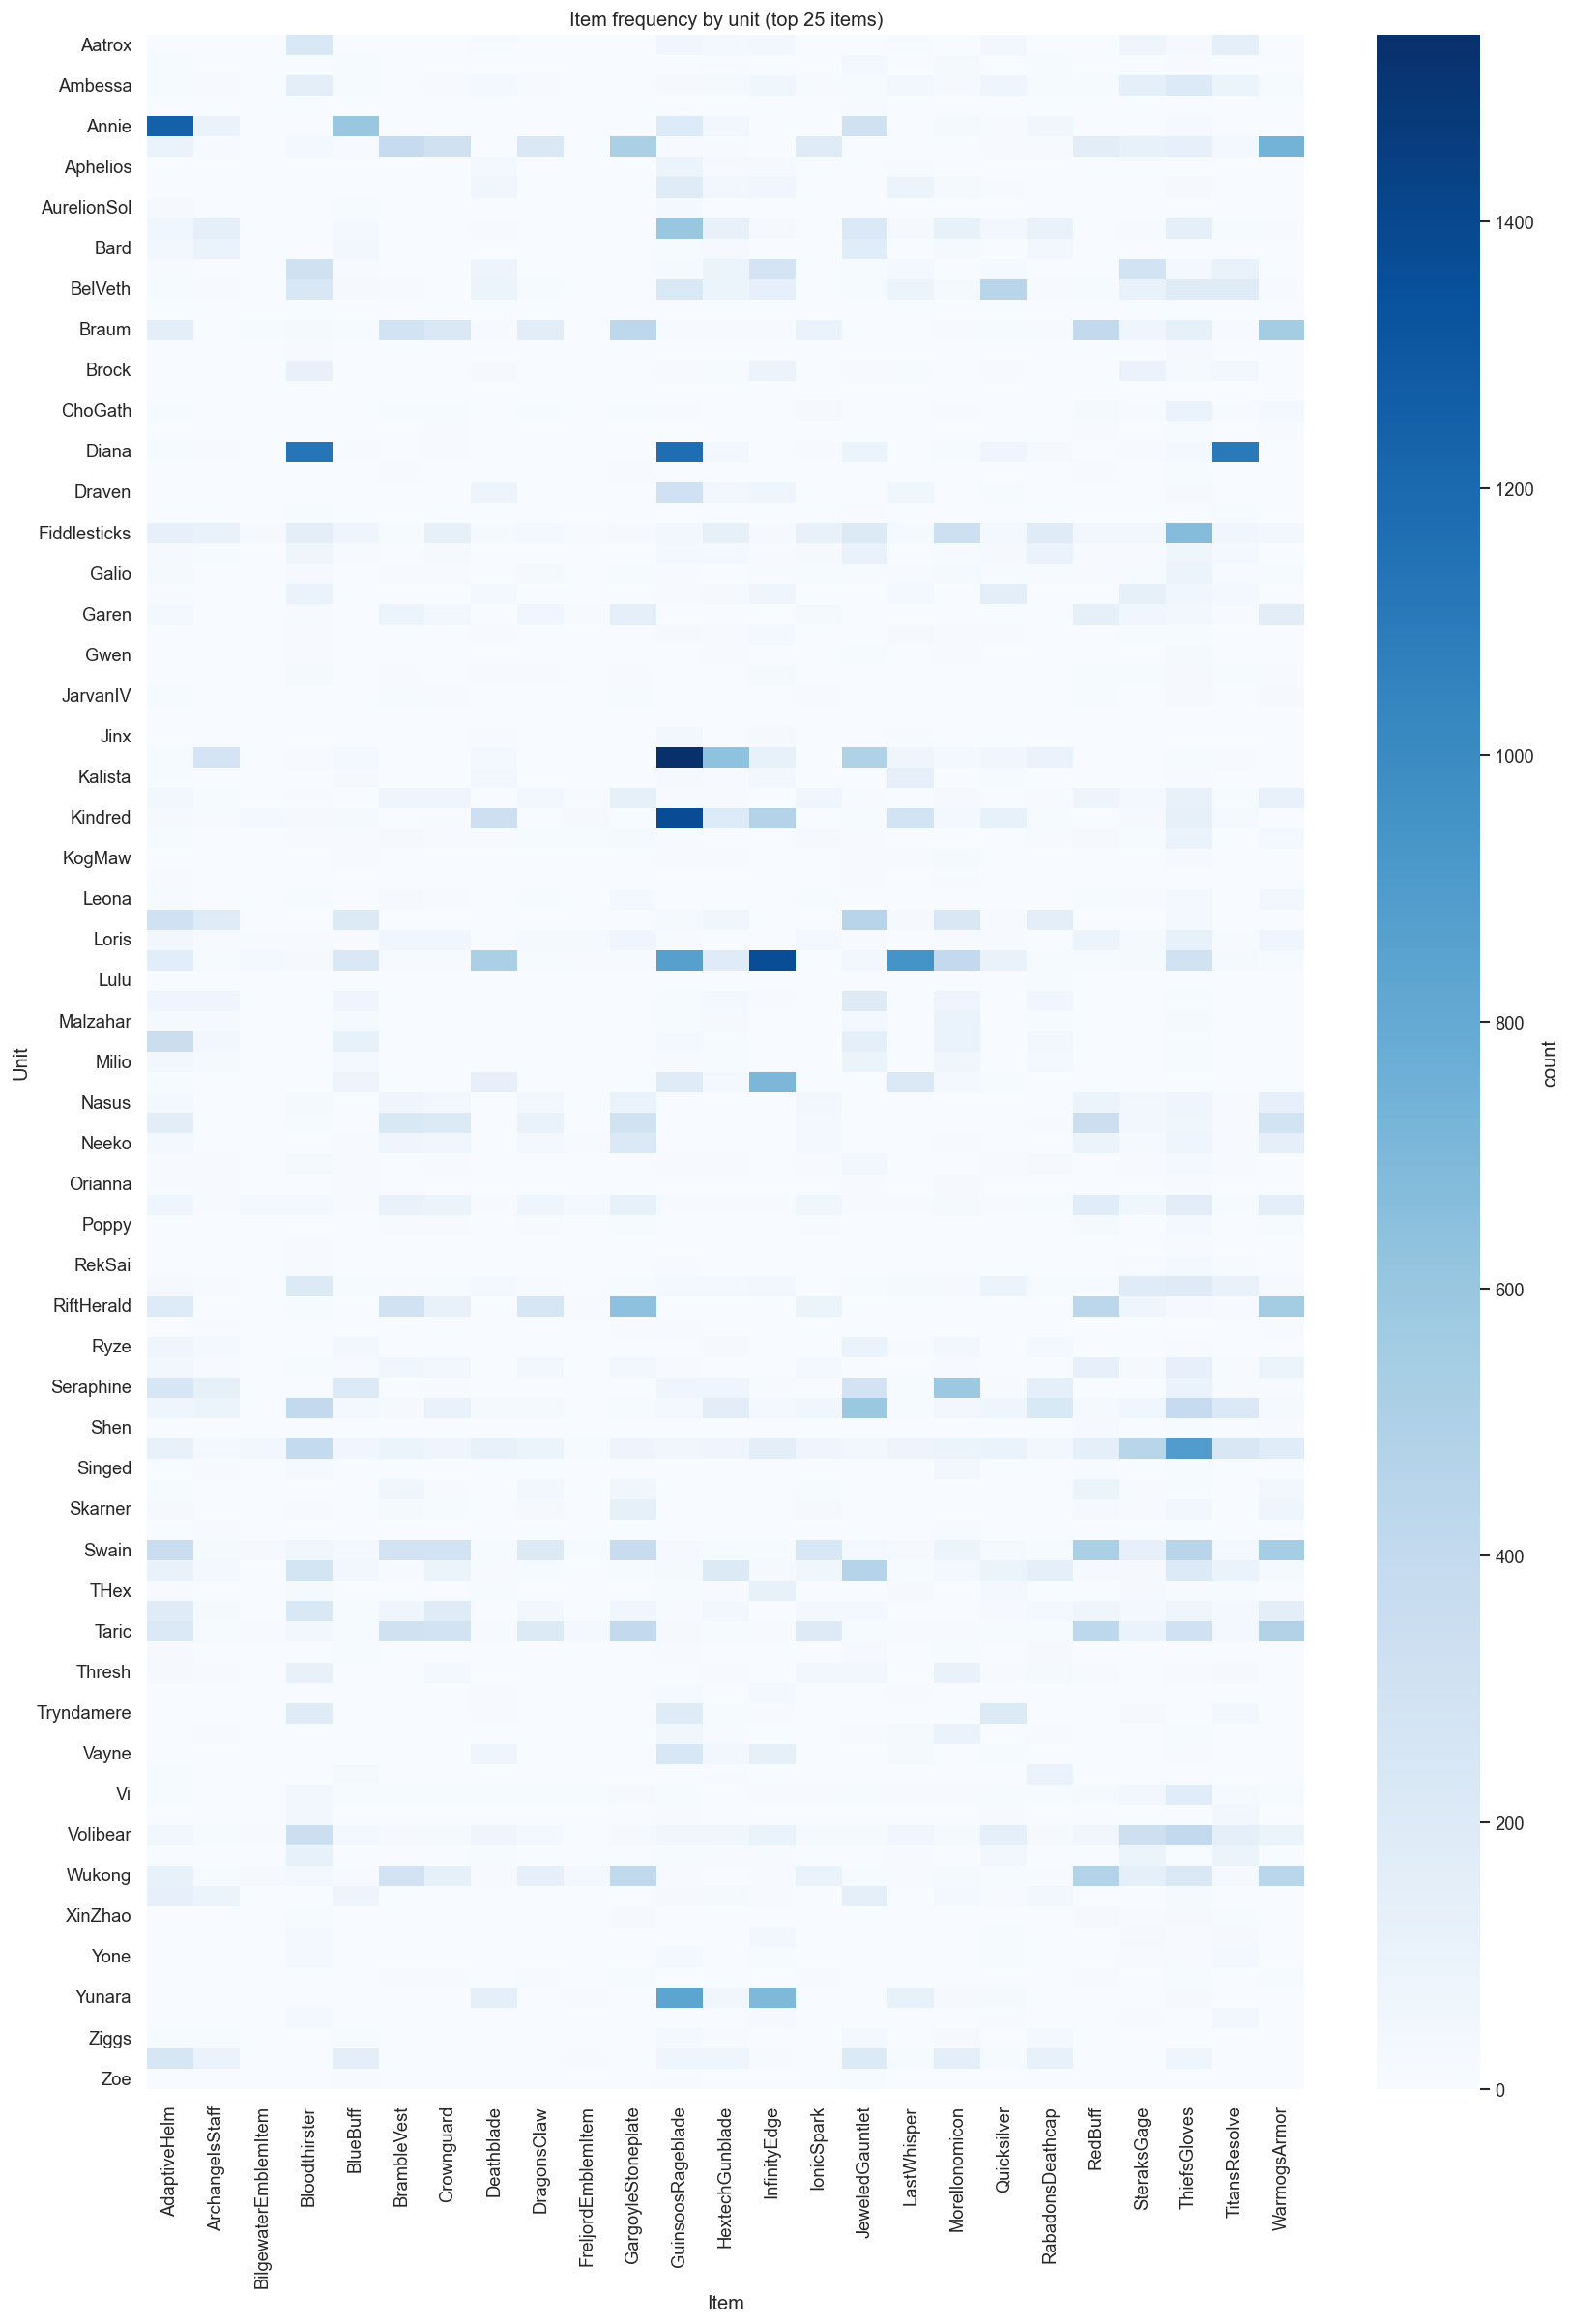

In [54]:

# Item heatmap: units vs items (all slots treated as entries, filtered to items in items_s16)
item_cols = [c for c in units.columns if c.startswith('item_')]
items_long = units[['unit_name'] + item_cols].set_index('unit_name').stack(dropna=True).reset_index()
items_long.columns = ['unit_name','slot','item']
items_long['item'] = items_long['item'].astype(str).str.strip()

valid_items = set(items_ref['name'].dropna())
items_long = items_long[items_long['item'].isin(valid_items)]

# Pivot to unit x item counts; limit to top items to keep plot readable
item_totals = items_long['item'].value_counts()
top_items = item_totals.head(25).index
heat_df = (
    items_long[items_long['item'].isin(top_items)]
    .groupby(['unit_name','item']).size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(14, max(6, 0.2 * len(heat_df))))
sns.heatmap(heat_df, cmap='Blues', cbar_kws={'label': 'count'})
plt.title('Item frequency by unit (top 25 items)')
plt.xlabel('Item')
plt.ylabel('Unit')
plt.xticks(rotation=90)
plt.tight_layout()
heatmap_path = FIGURES_DIR / "00_data_validation_items_heatmap.png"
plt.savefig(heatmap_path, bbox_inches='tight')
print(f"Saved item heatmap to {heatmap_path}")


Saved figure to /Users/zeoxzhang/Dev/teamfight_tactic_s16_analytics/outputs/figures/00_data_validation.png


PosixPath('/Users/zeoxzhang/Dev/teamfight_tactic_s16_analytics/outputs/figures/00_data_validation.png')

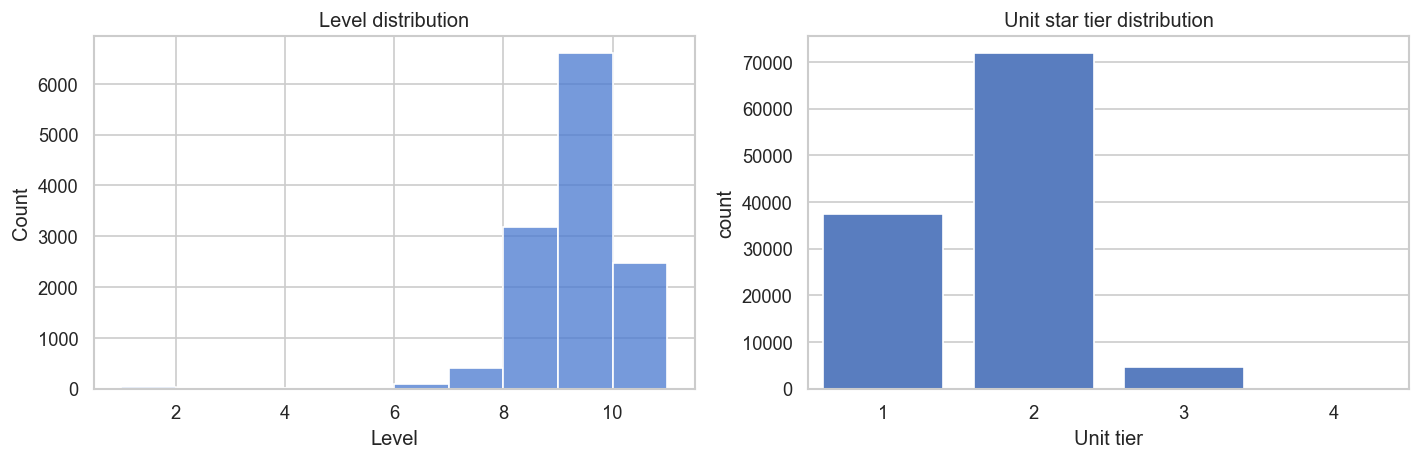

In [55]:

# Simple distributions: level and unit star tiers
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(participants['level'], bins=range(1, 12), ax=axes[0])
axes[0].set_title('Level distribution')
axes[0].set_xlabel('Level')

sns.countplot(x='unit_tier', data=units, ax=axes[1])
axes[1].set_title('Unit star tier distribution')
axes[1].set_xlabel('Unit tier')

fig.tight_layout()
fig_path = FIGURES_DIR / "00_data_validation.png"
fig.savefig(fig_path, bbox_inches='tight')
print(f"Saved figure to {fig_path}")
fig_path
